In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cross-validation 
from sklearn.model_selection import train_test_split, StratifiedKFold

# classification models 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC

# cox model 
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# mlp
from sklearn.neural_network import MLPClassifier

# eval 
from sklearn.metrics import precision_recall_curve


In [7]:
data_path = './heart_failure_dataset.csv'
df = pd.read_csv(data_path, index_col=False)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,41,0,148,0,40,0,374000.00,0.80,140,1,1,68,0
1,66,0,434,1,24,1,268112.43,1.21,135,1,1,138,1
2,70,0,93,0,35,0,185000.00,1.10,134,1,1,208,0
3,72,0,140,1,50,0,216218.24,0.98,134,1,0,32,0
4,60,0,235,1,38,0,329000.00,3.00,142,0,0,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,55,0,748,0,45,0,263000.00,1.30,137,1,0,88,0
896,44,0,582,1,30,1,263358.03,1.60,130,1,1,244,0
897,70,0,838,1,35,1,304117.75,0.80,133,1,0,144,1
898,77,0,107,0,50,1,405514.68,1.11,137,1,1,209,1


In [8]:
df = df.rename(columns={'DEATH_EVENT': 'event', 'time': 'time'})

# Prepare the input features and target variable
X = df.drop(columns=['time', 'event'])
y = df['event']  # Target variable (renamed DEATH_EVENT)
time = df['time']
y_with_time = pd.DataFrame({'event': y, 'time': time})

# Performing an 80/20 train-test split, stratified by 'event'
X_dev, X_test, y_dev_with_time, y_test_with_time = train_test_split(X, y_with_time, test_size=0.2, stratify=y, random_state=42)
y_dev = y_dev_with_time['event']
time_dev = y_dev_with_time['time']
y_test = y_test_with_time['event']
time_test = y_test_with_time['time']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cox model with ridge regression

In [9]:
C_values = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000, 10000]

# Track the best results
best_auroc_mean = 0
best_auroc_std = 0
best_metrics = None
best_hyperparams = None

# Perform grid search over C values
for C in C_values:
    print(f"Regularization strength: {C}")
    
    # Initialize lists to store the metrics for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auroc_scores = []
    auprc_scores = []
    concordance_indices = []

    # Perform 5-fold cross-validation
    for train_index, val_index in kf.split(X_dev, y_dev):
        # Get train and validation data
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]
        time_train_fold, time_val_fold = time_dev.iloc[train_index], time_dev.iloc[val_index]

        # Normalize the training set and apply the same params to val
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Prepare train and validation data
        train_data = pd.DataFrame(X_train_fold_scaled, columns=X.columns)
        train_data['time'] = time_train_fold.values
        train_data['event'] = y_train_fold.values
        val_data = pd.DataFrame(X_val_fold_scaled, columns=X.columns)
        val_data['time'] = time_val_fold.values
        val_data['event'] = y_val_fold.values

        # Fit Cox Proportional Hazards model
        cox_model = CoxPHFitter(penalizer=C, l1_ratio=0)  # Regularization using penalizer
        cox_model.fit(train_data, duration_col='time', event_col='event')

        # Predict the partial hazard for the validation set
        val_hazards = cox_model.predict_partial_hazard(val_data)

        # Evaluate using concordance index
        concordance_index_val = concordance_index(val_data['time'], -val_hazards, event_observed=val_data['event'])
        concordance_indices.append(concordance_index_val)

        # Calculate ROC curve and thresholds
        fpr, tpr, thresholds = roc_curve(y_val_fold, val_hazards)

        # Calculate the Youden index (TPR - FPR)
        youden_index = tpr - fpr

        # Find the index of the maximum Youden index
        optimal_threshold_index = np.argmax(youden_index)

        # Get the optimal threshold
        optimal_threshold = thresholds[optimal_threshold_index]

        # Classify the patients based on the optimal threshold
        y_val_pred = (val_hazards >= optimal_threshold).astype(int)

        # Calculate and store classification metrics
        accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
        precision_scores.append(precision_score(y_val_fold, y_val_pred))
        recall_scores.append(recall_score(y_val_fold, y_val_pred))
        f1_scores.append(f1_score(y_val_fold, y_val_pred))
        auroc_scores.append(roc_auc_score(y_val_fold, val_hazards))
        auprc_scores.append(average_precision_score(y_val_fold, val_hazards))

    # Calculate mean and standard deviation of AUROC
    auroc_mean = np.mean(auroc_scores)
    auroc_std = np.std(auroc_scores)

    # Check if this is the best AUROC so far
    if auroc_mean > best_auroc_mean:
        best_auroc_mean = auroc_mean
        best_auroc_std = auroc_std
        best_metrics = {
            'accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
            'precision': (np.mean(precision_scores), np.std(precision_scores)),
            'recall': (np.mean(recall_scores), np.std(recall_scores)),
            'f1_score': (np.mean(f1_scores), np.std(f1_scores)),
            'auroc': (auroc_mean, auroc_std),
            'auprc': (np.mean(auprc_scores), np.std(auprc_scores))
        }
        best_hyperparams = C

# Print the best results
print(f"Best AUROC: {best_metrics['auroc'][0]:.4f} ({best_metrics['auroc'][1]:.4f})")
print(f"Best hyperparameters: C = {best_hyperparams}")
print(f"Accuracy: Mean = {best_metrics['accuracy'][0]:.4f} ({best_metrics['accuracy'][1]:.4f})")
print(f"Precision: Mean = {best_metrics['precision'][0]:.4f} ({best_metrics['precision'][1]:.4f})")
print(f"Recall: Mean = {best_metrics['recall'][0]:.4f} ({best_metrics['recall'][1]:.4f})")
print(f"F1-Score: Mean = {best_metrics['f1_score'][0]:.4f} ({best_metrics['f1_score'][1]:.4f})")
print(f"AUROC: Mean = {best_metrics['auroc'][0]:.4f} ({best_metrics['auroc'][1]:.4f})")
print(f"AUPRC: Mean = {best_metrics['auprc'][0]:.4f} ({best_metrics['auprc'][1]:.4f})")


Regularization strength: 0
Regularization strength: 1e-05
Regularization strength: 0.0001
Regularization strength: 0.001
Regularization strength: 0.01
Regularization strength: 0.1
Regularization strength: 0.5
Regularization strength: 1
Regularization strength: 10
Regularization strength: 100
Regularization strength: 1000
Regularization strength: 10000
Best AUROC: 0.6864 (0.0178)
Best hyperparameters: C = 1
Accuracy: Mean = 0.6653 (0.0254)
Precision: Mean = 0.6793 (0.0556)
Recall: Mean = 0.6721 (0.1353)
F1-Score: Mean = 0.6625 (0.0594)
AUROC: Mean = 0.6864 (0.0178)
AUPRC: Mean = 0.6855 (0.0258)


In [10]:
# After determining the best hyperparameter 'C' from cross-validation:
best_C = best_hyperparams  # This is the best 'C' found during cross-validation

# Normalize the entire development set and the test set
scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)
X_test_scaled = scaler.transform(X_test)

# Prepare development and test data
train_data = pd.DataFrame(X_dev_scaled, columns=X.columns)
train_data['time'] = time_dev.values
train_data['event'] = y_dev.values
test_data = pd.DataFrame(X_test_scaled, columns=X.columns)
test_data['time'] = time_test.values
test_data['event'] = y_test.values

# Fit the Cox model using the best regularization parameter found on the entire development set
cox_model = CoxPHFitter(penalizer=best_C, l1_ratio=0)
cox_model.fit(train_data, duration_col='time', event_col='event')

# Predict the partial hazard for the test set
test_hazards = cox_model.predict_partial_hazard(test_data)

# Evaluate using the concordance index on the test set
concordance_index_test = concordance_index(test_data['time'], -test_hazards, event_observed=test_data['event'])
print(f"Concordance Index on test set: {concordance_index_test:.4f}")

# Calculate ROC curve and Youden's index for the test set
fpr, tpr, thresholds = roc_curve(y_test, test_hazards)

# Calculate the Youden index (TPR - FPR)
youden_index = tpr - fpr

# Find the index of the maximum Youden index
optimal_threshold_index = np.argmax(youden_index)

# Get the optimal threshold for binary classification
optimal_threshold = thresholds[optimal_threshold_index]

# Classify the patients based on the optimal threshold
y_test_pred = (test_hazards >= optimal_threshold).astype(int)

# Calculate classification metrics on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
auroc_test = roc_auc_score(y_test, test_hazards)
auprc_test = average_precision_score(y_test, test_hazards)

# Print the test set performance
print(f"Accuracy on test set: {accuracy_test:.4f}")
print(f"Precision on test set: {precision_test:.4f}")
print(f"Recall on test set: {recall_test:.4f}")
print(f"F1-Score on test set: {f1_test:.4f}")
print(f"AUROC on test set: {auroc_test:.4f}")
print(f"AUPRC on test set: {auprc_test:.4f}")

Concordance Index on test set: 0.7244
Accuracy on test set: 0.7500
Precision on test set: 0.7674
Recall on test set: 0.7253
F1-Score on test set: 0.7458
AUROC on test set: 0.7921
AUPRC on test set: 0.7714


# Visualizations

In [11]:
orange_color = (233/255, 116/255, 81/255)
yellow_color = (1,205/255,116/255)

In [12]:
coefficients = cox_model.params_

# Sort the coefficients by absolute value to get the most important features
top_features = coefficients.abs().sort_values(ascending=False)

# Print the top features and their coefficients
print("Top selected features and their coefficients (log hazard ratios):")
print(top_features)

Top selected features and their coefficients (log hazard ratios):
covariate
age                         0.124507
ejection_fraction           0.089276
serum_creatinine            0.084180
serum_sodium                0.070175
high_blood_pressure         0.043261
anaemia                     0.034347
creatinine_phosphokinase    0.030834
smoking                     0.030165
sex                         0.014637
platelets                   0.009199
diabetes                    0.007183
Name: coef, dtype: float64


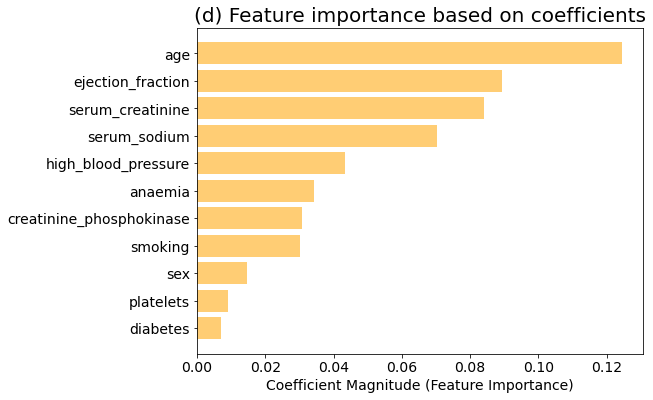

In [13]:
# Extract the feature coefficients (log hazard ratios for the Cox model)
coefficients = cox_model.params_

importance = np.abs(coefficients)
sorted_idx = importance.sort_values(ascending=False).index
sorted_importance = importance[sorted_idx]

# Plot the feature importance as a bar chart
plt.figure(figsize=(8, 6))
plt.barh(sorted_idx, sorted_importance, color=yellow_color)
plt.xlabel('Coefficient Magnitude (Feature Importance)', fontsize=14)
plt.title('(d) Feature importance based on coefficients', fontsize=20)
plt.gca().invert_yaxis()  
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()


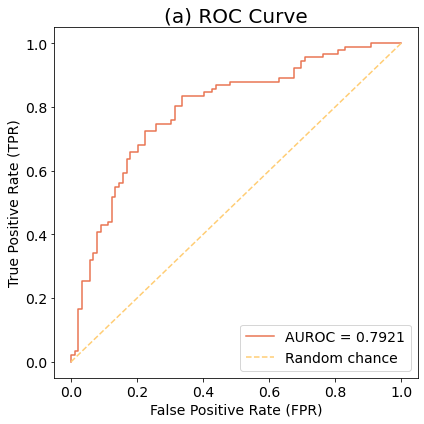

In [14]:
# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, test_hazards)

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_hazards)

# Extract the feature coefficients (log hazard ratios for the Cox model)
coefficients = cox_model.params_
importance = np.abs(coefficients)
sorted_idx = importance.sort_values(ascending=False).index
sorted_importance = importance[sorted_idx]

# 1st Figure: ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color=orange_color, label=f'AUROC = {auroc_test:.4f}')
plt.plot([0, 1], [0, 1], color=yellow_color, linestyle='--',label='Random chance')  # Random classifier
plt.title('(a) ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc="lower right", fontsize=14, title_fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()


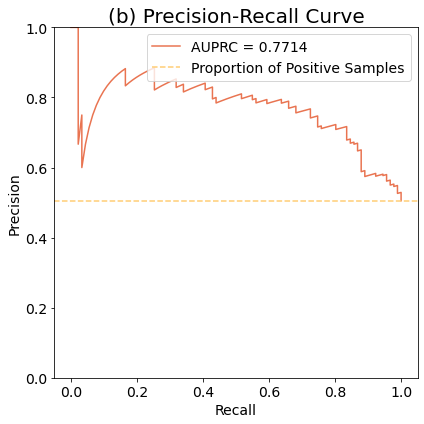

In [15]:
proportion_positive = sum(y_test) / len(y_test)  # This gives the proportion of positive samples

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color=orange_color, label=f'AUPRC = {auprc_test:.4f}')
plt.ylim(0, 1) 
plt.axhline(y=proportion_positive, color=yellow_color, linestyle='--', label='Proportion of Positive Samples')
plt.title('(b) Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc="upper right", fontsize=14, title_fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

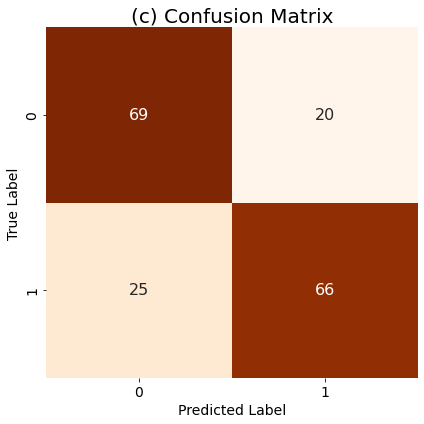

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn with the custom color map
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False, annot_kws={"size": 16})

# Titles and labels
plt.title('(c) Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tick_params(axis='both', labelsize=14)

# Display the plot
plt.tight_layout()
plt.show()